In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import random
from torch.autograd import Variable
import copy
from torch import nn, optim
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv
import time
import math


In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_seed(SEED)

In [3]:
class Argments():
  def __init__(self):
    self.batch_size = 40
    self.test_batch = 1000
    self.global_epochs = 500
    self.local_epochs = 2
    self.lr = None
    self.momentum = 0.9
    self.weight_decay = 10**-4.0
    self.clip = 20.0
    self.partience = 500
    self.worker_num = 20
    self.sample_num = 20
    self.cluster_list = [1,2,3,4]
    self.cluster_num = None
    self.turn_of_cluster_num = [0,250,375,450]
    self.turn_of_replacement_model = list(range(self.global_epochs))
    self.unlabeleddata_size = 1000
    self.device = torch.device('cuda:0'if torch.cuda.is_available() else'cpu')
    self.criterion_ce = nn.CrossEntropyLoss()
    self.criterion_kl = nn.KLDivLoss(reduction='batchmean')
    
    self.alpha_label = 0.5
    self.alpha_size = 10

args = Argments()

In [4]:
lr = 0

In [6]:
lr_list = []
lr_list.append(10**-3.0)
lr_list.append(10**-2.5)
lr_list.append(10**-2.0)
lr_list.append(10**-1.5)
lr_list.append(10**-1.0)
lr_list.append(10**-0.5)
lr_list.append(10**0.0)
lr_list.append(10**0.5)

args.lr = lr_list[lr]

In [9]:
class LocalDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label
    
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
class GlobalDataset(torch.utils.data.Dataset):
  def __init__(self,federated_dataset,transform=None):
    self.transform = transform
    self.data = []
    self.label = []
    for dataset in federated_dataset:
      for (data,label) in dataset:
        self.data.append(data)
        self.label.append(label)

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = self.label[idx]
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

class UnlabeledDataset(torch.utils.data.Dataset):
  def __init__(self,transform=None):
    self.transform = transform
    self.data = []
    self.target = None

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = 'unlabeled'
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

In [10]:
def get_dataset(Centralized=False,unlabeled_data=False):
    
    transform_train = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomCrop(32, padding=2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])
    transform_test = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])

    # download train data
    all_trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
    #trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

    # download test data
    all_testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

    
    ## get unlabeled dataset
    if unlabeled_data:
        unlabeled_dataset = UnlabeledDataset(transform_test)
        idx = sorted(random.sample(range(len(all_trainset)),args.unlabeleddata_size))
        unlabeled_dataset.data = np.array([all_trainset.data[i]  for i in idx])
        all_trainset.data = np.delete(all_trainset.data,idx,0)
        all_trainset.targets = np.delete(all_trainset.targets,idx,0)
    all_train_data = np.array(all_trainset.data)
    all_train_label = np.array(all_trainset.targets)
    all_test_data = np.array(all_testset.data)
    all_test_label = np.array(all_testset.targets)
    print('Train:{} Test:{}'.format(len(all_train_data),len(all_test_data)))


    ## Data size heterogeneity
    data_proportions = np.random.dirichlet(np.repeat(args.alpha_size, args.worker_num))
    train_data_proportions = np.array([0 for _ in range(args.worker_num)])
    test_data_proportions = np.array([0 for _ in range(args.worker_num)])
    for i in range(len(data_proportions)):
        if i==(len(data_proportions)-1):
            train_data_proportions = train_data_proportions.astype('int64')
            test_data_proportions = test_data_proportions.astype('int64')
            train_data_proportions[-1] = len(all_train_data) - np.sum(train_data_proportions[:-1])
            test_data_proportions[-1] = len(all_test_data) - np.sum(test_data_proportions[:-1])
        else:
            train_data_proportions[i] = (data_proportions[i] * len(all_train_data))
            test_data_proportions[i] = (data_proportions[i] * len(all_test_data))
    min_size = 0
    K = 10

    '''
    label_list = np.arange(10)
    np.random.shuffle(label_list)
    '''
    label_list = list(range(K))


    ## Data distribution heterogeneity
    while min_size<10:
        idx_train_batch = [[] for _ in range(args.worker_num)]
        idx_test_batch = [[] for _ in range(args.worker_num)]
        for k in label_list:
            proportions_train = np.random.dirichlet(np.repeat(args.alpha_label, args.worker_num))
            proportions_test = copy.deepcopy(proportions_train)
            idx_k_train = np.where(all_train_label == k)[0]
            idx_k_test = np.where(all_test_label == k)[0]
            np.random.shuffle(idx_k_train)
            np.random.shuffle(idx_k_test)
            ## Balance (train)
            proportions_train = np.array([p*(len(idx_j)<train_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_train,idx_train_batch))])
            proportions_train = proportions_train/proportions_train.sum()
            proportions_train = (np.cumsum(proportions_train)*len(idx_k_train)).astype(int)[:-1]
            idx_train_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_train_batch,np.split(idx_k_train,proportions_train))]

            ## Balance (test)
            proportions_test = np.array([p*(len(idx_j)<test_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_test,idx_test_batch))])
            proportions_test = proportions_test/proportions_test.sum()
            proportions_test = (np.cumsum(proportions_test)*len(idx_k_test)).astype(int)[:-1]
            idx_test_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_test_batch,np.split(idx_k_test,proportions_test))]

            min_size = min([len(idx_j) for idx_j in idx_train_batch])

    federated_trainset = []
    federated_testset = []
    for i in range(args.worker_num):
        ## create trainset
        data = [all_train_data[idx] for idx in idx_train_batch[i]]
        label = [all_train_label[idx] for idx in idx_train_batch[i]]
        federated_trainset.append(LocalDataset())
        federated_trainset[-1].data = data
        federated_trainset[-1].label = label

        ## create testset
        data = [all_test_data[idx] for idx in idx_test_batch[i]]
        label = [all_test_label[idx] for idx in idx_test_batch[i]]
        federated_testset.append(LocalDataset())
        federated_testset[-1].data = data
        federated_testset[-1].label = label

        
    ## split trainset
    federated_valset = [None]*args.worker_num
    for i in range(args.worker_num):
        n_samples = len(federated_trainset[i])
        if n_samples==1:
            train_subset = federated_trainset[i]
            val_subset = copy.deepcopy(federated_trainset[i])
        else:
            train_size = int(len(federated_trainset[i]) * 0.8) 
            val_size = n_samples - train_size 
            train_subset,val_subset = torch.utils.data.random_split(federated_trainset[i], [train_size, val_size])

        federated_trainset[i] = DatasetFromSubset(train_subset)
        federated_valset[i] = DatasetFromSubset(val_subset)

    ## show data distribution
    H = 4
    W = 5
    fig, axs = plt.subplots(H, W, figsize=(20, 5))
    x = np.arange(1,11)
    for i, (trainset,valset,testset) in enumerate(zip(federated_trainset,federated_valset,federated_testset)):
        bottom = [0]*10
        count = [0]*10
        for _,label in trainset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in valset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in testset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        #axs[int(i/W), i%W].title("worker{}".format(i+1), fontsize=12, color = "green")

    plt.show()

    ## get global dataset
    if Centralized:
        global_trainset = GlobalDataset(federated_trainset)
        global_valset = GlobalDataset(federated_valset)
        global_testset =  GlobalDataset(federated_testset)
        
        #show_cifer(global_trainset.data,global_testset.label, cifar10_labels)

        global_trainset.transform = transform_train
        global_valset.transform = transform_test
        global_testset.transform = transform_test

        global_trainloader = torch.utils.data.DataLoader(global_trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
        global_valloader = torch.utils.data.DataLoader(global_valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
        global_testloader = torch.utils.data.DataLoader(global_testset,batch_size=args.test_batch,shuffle=False,num_workers=2)

    ## set transform
    for i in range(args.worker_num):
        federated_trainset[i].transform = transform_train
        federated_valset[i].transform = transform_test
        federated_testset[i].transform = transform_test
    
    if Centralized and unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader,unlabeled_dataset
    if Centralized:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader
    elif unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,unlabeled_dataset
    else:
        return federated_trainset,federated_valset,federated_testset

Files already downloaded and verified
Files already downloaded and verified
Train:49000 Test:10000


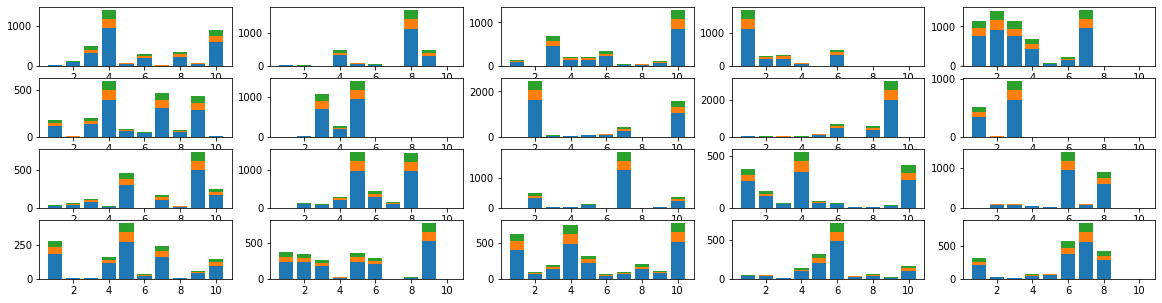

In [11]:
federated_trainset,federated_valset,federated_testset,unlabeled_dataset = get_dataset(unlabeled_data=True)

In [12]:
total = [0,0,0]
for i in range(args.worker_num):
    total[0]+=len(federated_trainset[i])
    total[1]+=len(federated_valset[i])
    total[2]+=len(federated_testset[i])
print(total)

[39191, 9809, 10000]


In [14]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            #print("in_channels: {}, v: {}".format(in_channels, v))
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


class VGGConvBlocks(nn.Module):
    '''
    VGG containers that only contains the conv layers 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class VGGContainer(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, input_dim, hidden_dims, num_classes=10):
        super(VGGContainer, self).__init__()
        self.features = features
        # note: we hard coded here a bit by assuming we only have two hidden layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Linear(hidden_dims[1], num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def matched_vgg11(matched_shapes):
    # [(67, 27), (67,), (132, 603), (132,), (260, 1188), (260,), (261, 2340), (261,), (516, 2349), (516,), (517, 4644), (517,), 
    # (516, 4653), (516,), (516, 4644), (516,), (516, 515), (515,), (515, 515), (515,), (515, 10), (10,)]
    processed_matched_shape = [matched_shapes[0][0], 
                                'M', 
                                matched_shapes[2][0], 
                                'M', 
                                matched_shapes[4][0], 
                                matched_shapes[6][0], 
                                'M', 
                                matched_shapes[8][0], 
                                matched_shapes[10][0], 
                                'M', 
                                matched_shapes[12][0], 
                                matched_shapes[14][0], 
                                'M']
    return VGGContainer(make_layers(processed_matched_shape), input_dim=matched_shapes[16][0], 
            hidden_dims=[matched_shapes[16][1], matched_shapes[18][1]], num_classes=10)


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn(num_classes=10):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes=num_classes)


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [15]:
class KMeans(object):

    def __init__(self, n_clusters=2, max_iter=300):

        self.n_clusters = n_clusters
        self.max_iter = max_iter

        self.cluster_centers_ = None

    def fit_predict(self, features):

        feature_indexes = np.arange(len(features))
        np.random.shuffle(feature_indexes)
        initial_centroid_indexes = feature_indexes[:self.n_clusters]
        self.cluster_centers_ = features[initial_centroid_indexes]

        pred = np.zeros(features.shape)
        
        for _ in range(self.max_iter):

            new_pred = np.array([
                np.array([
                    self.Euclidean_distance(p, centroid)
                    for centroid in self.cluster_centers_
                ]).argmin()
                for p in features
            ])

            if np.all(new_pred == pred):
                break

            pred = new_pred
            
            self.cluster_centers_ = np.array([features[pred == i].mean(axis=0)
                                              for i in range(self.n_clusters)])

        return pred

    def KLD(self, p0, p1):
        P = torch.from_numpy(p0.astype(np.float32)).clone()
        Q = torch.from_numpy(p1.astype(np.float32)).clone()
        P = F.softmax(Variable(P), dim=1)
        Q = F.softmax(Variable(Q), dim=1)
        kld = ((P/(P+Q))*(P * (P / ((P/(P+Q))*P + (Q/(P+Q))*Q)).log())).sum() + ((Q/(P+Q))*(Q * (Q / ((P/(P+Q))*P + (Q/(P+Q))*Q)).log())).sum()
        return kld
    
    def Euclidean_distance(self, p0, p1):
        return np.sum((p0 - p1) ** 2)

In [16]:
class Server():
  def __init__(self,unlabeled_dataset):
    self.cluster = None
    self.models = None
    self.unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset,batch_size=args.batch_size,shuffle=False,num_workers=2)

  def create_worker(self,federated_trainset,federated_valset,federated_testset,client_best_model):
    workers = []
    for i in range(args.worker_num):
      workers.append(Worker(i,federated_trainset[i],federated_valset[i],federated_testset[i],client_best_model[i]))
    return workers

  def sample_worker(self,workers):
    sample_worker = []
    sample_worker_num = random.sample(range(args.worker_num),args.sample_num)
    for i in sample_worker_num:
      sample_worker.append(workers[i])
    return sample_worker

  def collect_model(self,workers):
    self.models = [None]*args.worker_num
    for worker in workers:
      self.models[worker.id] = copy.deepcopy(worker.local_model)

  def send_model(self,workers):
    for worker in workers:
      worker.local_model = copy.deepcopy(self.models[worker.id])
      worker.other_model = copy.deepcopy(self.models[worker.other_model_id])
        
  def return_model(self,workers):
    for worker in workers:
      worker.local_model = copy.deepcopy(self.models[worker.local_model_id])
      worker.local_model_id = worker.id
    del self.models
    
  def aggregate_model(self,workers):   
    new_params = []
    train_model_id = []
    train_model_id_count = []
    for worker in workers:
      worker_state = worker.local_model.state_dict()
      if worker.id in train_model_id:
        i = train_model_id.index(worker.id)
        for key in worker_state.keys():
          new_params[i][key] += worker_state[key]
        train_model_id_count[i] += 1
      else:
        new_params.append(OrderedDict())
        train_model_id.append(worker.id)
        train_model_id_count.append(1)
        i = train_model_id.index(worker.id)
        for key in worker_state.keys():
          new_params[i][key] = worker_state[key]
        
      worker_state = worker.other_model.state_dict()
      if worker.other_model_id in train_model_id:
        i = train_model_id.index(worker.other_model_id)
        for key in worker_state.keys():
          new_params[i][key] += worker_state[key]
        train_model_id_count[i] += 1
      else:
        new_params.append(OrderedDict())
        train_model_id.append(worker.other_model_id)
        train_model_id_count.append(1)
        i = train_model_id.index(worker.other_model_id)
        for key in worker_state.keys():
          new_params[i][key] = worker_state[key]
        
      worker.local_model = worker.local_model.to('cpu')
      worker.other_model = worker.other_model.to('cpu')
      del worker.local_model,worker.other_model
    
    for i,model_id in enumerate(train_model_id):
      for key in new_params[i].keys():
        new_params[i][key] = new_params[i][key]/train_model_id_count[i]
      self.models[model_id].load_state_dict(new_params[i])
      
  '''clustering by kmeans'''  
  def clustering(self,workers):
    if args.cluster_num==1:
        pred = [0]*len(workers)
        worker_id_list = []
        for worker in workers:
            worker_id_list.append(worker.id)
    else:
        with torch.no_grad():
            worker_softmax_targets = [[] for i in range(len(workers))]
            worker_id_list = []
            count = 0
            for i,model in enumerate(self.models):
              if model==None:
                pass
              else:
                model = model.to(args.device)
                model.eval()
                for data,_ in self.unlabeled_dataloader:
                  data = data.to(args.device)
                  worker_softmax_targets[count].append(model(data).to('cpu').detach().numpy())
                worker_softmax_targets[count] = np.array(worker_softmax_targets[count])
                model = model.to('cpu')
                worker_id_list.append(i)
                count += 1
            worker_softmax_targets = np.array(worker_softmax_targets)
            kmeans = KMeans(n_clusters=args.cluster_num)
            pred = kmeans.fit_predict(worker_softmax_targets)
    self.cluster = []
    for i in range(args.cluster_num):
      self.cluster.append([])
    for i,cls in enumerate(pred):
      self.cluster[cls].append(worker_id_list[i])
    for worker in workers:
      idx = worker_id_list.index(worker.id)
      worker.cluster_num = pred[idx]
        
  def decide_other_model(self,workers):
    for worker in workers:
      cls = worker.cluster_num
      '''if number of worker in cluster is one, other model is decided by random in all workers. '''
      if len(self.cluster[cls])==1:
        while True:
          other_worker = random.choice(workers)
          other_model_id = other_worker.id
          if worker.id!=other_model_id:
            break
      else:
        while True:
          other_model_id = random.choice(self.cluster[cls])
          if worker.id!=other_model_id:
            break
      worker.other_model_id = other_model_id

In [17]:
class Worker():
  def __init__(self,i,trainset,valset,testset,best_model):
    self.id = i
    self.cluster_num = None
    self.trainloader = torch.utils.data.DataLoader(trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
    self.valloader = torch.utils.data.DataLoader(valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.testloader = torch.utils.data.DataLoader(testset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    if best_model==1:
      self.local_model = vgg11()
    elif best_model==2:
      self.local_model = vgg13()
    elif best_model==3:
      self.local_model = vgg16()
    elif best_model==4:
      self.local_model = vgg19()
    self.local_model_id = i
    self.other_model = None
    self.other_model_id = None
    self.train_data_num = len(trainset)
    self.test_data_num = len(testset)

  def local_train(self):
    self.local_model = self.local_model.to(args.device)
    self.other_model = self.other_model.to(args.device)
    local_optimizer = optim.SGD(self.local_model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
    other_optimizer = optim.SGD(self.other_model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
    self.local_model.train()
    self.other_model.train()
    for epoch in range(args.local_epochs):
      running_loss = 0.0
      correct = 0
      count = 0
      for (data,labels) in self.trainloader:
        data,labels = Variable(data),Variable(labels)
        data,labels = data.to(args.device),labels.to(args.device)
        local_optimizer.zero_grad()
        other_optimizer.zero_grad()
        local_outputs = self.local_model(data)
        other_outputs = self.other_model(data)
        #train local_model
        ce_loss = args.criterion_ce(local_outputs,labels)
        kl_loss = args.criterion_kl(F.log_softmax(local_outputs, dim = 1),F.softmax(Variable(other_outputs), dim=1))
        loss = ce_loss + kl_loss
        running_loss += loss.item()
        predicted = torch.argmax(local_outputs,dim=1)
        correct += (predicted==labels).sum().item()
        count += len(labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.local_model.parameters(), args.clip)
        local_optimizer.step()

        #train other_model
        ce_loss = args.criterion_ce(other_outputs,labels)
        kl_loss = args.criterion_kl(F.log_softmax(other_outputs, dim = 1),F.softmax(Variable(local_outputs), dim=1))
        loss = ce_loss + kl_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.other_model.parameters(), args.clip)
        other_optimizer.step()
        
    return 100.0*correct/count,running_loss/len(self.trainloader)

        
  def validate(self):
    acc,loss = test(self.local_model,args.criterion_ce,self.valloader)
    return acc,loss


  def model_replacement(self):
    _,loss_local = test(self.local_model,args.criterion_ce,self.valloader)
    _,loss_other = test(self.other_model,args.criterion_ce,self.valloader)
    if loss_other<loss_local:
        self.local_model_id = self.other_model_id

In [18]:
def train(model,criterion,trainloader,epochs):
  optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    count = 0
    for (data,labels) in trainloader:
      data,labels = Variable(data),Variable(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs,labels)
      running_loss += loss.item()
      predicted = torch.argmax(outputs,dim=1)
      correct += (predicted==labels).sum().item()
      count += len(labels)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
      optimizer.step()

  return 100.0*correct/count,running_loss/len(trainloader)



In [19]:
def test(model,criterion,testloader):
  model.eval()
  running_loss = 0.0
  correct = 0
  count = 0
  for (data,labels) in testloader:
    data,labels = data.to(args.device),labels.to(args.device)
    outputs = model(data)
    running_loss += criterion(outputs,labels).item()
    predicted = torch.argmax(outputs,dim=1)
    correct += (predicted==labels).sum().item()
    count += len(labels)

  accuracy = 100.0*correct/count
  loss = running_loss/len(testloader)


  return accuracy,loss

In [20]:
class Early_Stopping():
  def __init__(self,partience):
    self.step = 0
    self.loss = float('inf')
    self.partience = partience

  def validate(self,loss):
    if self.loss<loss:
      self.step += 1
      if self.step>self.partience:
        return True
    else:
      self.step = 0
      self.loss = loss

    return False

In [21]:
with open('../client_best_model/client_best_model_cifar10_42.csv') as fp:
    csvList = list(csv.reader(fp))
client_best_model = [int(item) for subList in csvList for item in subList]

In [22]:
server = Server(unlabeled_dataset)
workers = server.create_worker(federated_trainset,federated_valset,federated_testset,client_best_model)
acc_train = []
loss_train = []
acc_valid = []
loss_valid = []

early_stopping = Early_Stopping(args.partience)

start = time.time()

for epoch in range(args.global_epochs):
  if epoch in args.turn_of_cluster_num:
    idx = args.turn_of_cluster_num.index(epoch)
    args.cluster_num = args.cluster_list[idx]
  sample_worker = server.sample_worker(workers)
  server.collect_model(sample_worker)
  server.clustering(sample_worker)
  server.decide_other_model(sample_worker)
  server.send_model(sample_worker)

  acc_train_avg = 0.0
  loss_train_avg = 0.0
  acc_valid_avg = 0.0
  loss_valid_avg = 0.0
  for worker in sample_worker:
    acc_train_tmp,loss_train_tmp = worker.local_train()
    acc_valid_tmp,loss_valid_tmp = worker.validate()
    acc_train_avg += acc_train_tmp/len(sample_worker)
    loss_train_avg += loss_train_tmp/len(sample_worker)
    acc_valid_avg += acc_valid_tmp/len(sample_worker)
    loss_valid_avg += loss_valid_tmp/len(sample_worker)
  if epoch in args.turn_of_replacement_model:
    for worker in sample_worker:
      worker.model_replacement()
  server.aggregate_model(sample_worker)
  server.return_model(sample_worker)
  '''
  server.model.to(args.device)
  for worker in workers:
    acc_valid_tmp,loss_valid_tmp = test(server.model,args.criterion,worker.valloader)
    acc_valid_avg += acc_valid_tmp/len(workers)
    loss_valid_avg += loss_valid_tmp/len(workers)
  server.model.to('cpu')
  '''
  print('Epoch{}  loss:{}  accuracy:{}'.format(epoch+1,loss_valid_avg,acc_valid_avg))
  acc_train.append(acc_train_avg)
  loss_train.append(loss_train_avg)
  acc_valid.append(acc_valid_avg)
  loss_valid.append(loss_valid_avg)

  if early_stopping.validate(loss_valid_avg):
    print('Early Stop')
    break
    
end = time.time()

Epoch1  loss:1.7584694743156433  accuracy:42.59606778372204
Epoch2  loss:1.5236206412315365  accuracy:44.05957070839748
Epoch3  loss:1.5245722144842149  accuracy:43.98694586440018
Epoch4  loss:1.527425765991211  accuracy:43.79653328393967
Epoch5  loss:1.5282279461622237  accuracy:44.72084428811865
Epoch6  loss:1.563296610116959  accuracy:45.15482590905318
Epoch7  loss:1.4778601437807082  accuracy:44.25939352346806
Epoch8  loss:1.5054776847362517  accuracy:45.09796270230695
Epoch9  loss:1.5064044594764712  accuracy:45.66320737997284
Epoch10  loss:1.4515793114900588  accuracy:46.05181459680158
Epoch11  loss:1.4186937838792801  accuracy:47.9681866233663
Epoch12  loss:1.4451943695545197  accuracy:50.45497444368905
Epoch13  loss:1.3802657991647724  accuracy:52.57140013801806
Epoch14  loss:1.3419563442468645  accuracy:51.86087456436666
Epoch15  loss:1.3299528390169144  accuracy:53.26601271792851
Epoch16  loss:1.273381093144417  accuracy:54.31866926006681
Epoch17  loss:1.291483849287033  accu

Epoch136  loss:0.6698842480778694  accuracy:77.16435998694942
Epoch137  loss:0.6635412469506264  accuracy:76.71719202568177
Epoch138  loss:0.6709774658083916  accuracy:76.74604120981829
Epoch139  loss:0.6663427047431472  accuracy:77.17712703193828
Epoch140  loss:0.6581012316048145  accuracy:77.5774998794743
Epoch141  loss:0.6440126456320285  accuracy:77.68023076613069
Epoch142  loss:0.6638354063034058  accuracy:77.43542224929111
Epoch143  loss:0.6331939935684203  accuracy:78.1848596445607
Epoch144  loss:0.6561351440846919  accuracy:78.1138303573166
Epoch145  loss:0.6309553414583207  accuracy:78.34103022033855
Epoch146  loss:0.6376551426947117  accuracy:78.28938960992696
Epoch147  loss:0.6393580377101898  accuracy:77.90839938045526
Epoch148  loss:0.635223727673292  accuracy:78.19703118835987
Epoch149  loss:0.6243551850318909  accuracy:78.50041771185366
Epoch150  loss:0.6311630584299565  accuracy:78.40914477820893
Epoch151  loss:0.6221606895327567  accuracy:78.59120445306083
Epoch152  lo

/home/acc12212vx/jupyter_env/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Epoch251  loss:0.4608701281249523  accuracy:84.61927337643378
Epoch252  loss:0.4446806754916906  accuracy:85.09165405906126
Epoch253  loss:0.44391835145652275  accuracy:85.39934584784294
Epoch254  loss:0.45495100365951663  accuracy:84.54557010294388
Epoch255  loss:0.4657270371913909  accuracy:84.54429725029347
Epoch256  loss:0.45092328004539006  accuracy:85.00209531253864
Epoch257  loss:0.4495008669793606  accuracy:84.89287872563501
Epoch258  loss:0.4555936288088561  accuracy:84.69325197349079
Epoch259  loss:0.4502113096415996  accuracy:85.24327598998565
Epoch260  loss:0.44392202831804756  accuracy:85.23168409794762
Epoch261  loss:0.4465039547532797  accuracy:84.99000754722991
Epoch262  loss:0.4493681117892266  accuracy:84.9313819021061
Epoch263  loss:0.44729447439312936  accuracy:85.14901510787668
Epoch264  loss:0.4438075341284275  accuracy:85.38186233846797
Epoch265  loss:0.4412774061784148  accuracy:85.37252126198882
Epoch266  loss:0.4385430753231049  accuracy:85.42222135324599
Epoc

/home/acc12212vx/jupyter_env/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice.
/home/acc12212vx/jupyter_env/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Epoch320  loss:0.40930587965995086  accuracy:86.45087276342126
Epoch321  loss:0.4125158237293362  accuracy:86.02461476304259
Epoch322  loss:0.41064875461161143  accuracy:86.41787369093804
Epoch323  loss:0.4109006432816386  accuracy:86.37717268492003
Epoch324  loss:0.4076172970235348  accuracy:86.59705204835856
Epoch325  loss:0.4103543240576982  accuracy:86.41944496456469
Epoch326  loss:0.4074804082512856  accuracy:86.49427268127117
Epoch327  loss:0.4115106572397054  accuracy:86.33065594752935
Epoch328  loss:0.4061454679816961  accuracy:86.48428133276946
Epoch329  loss:0.41495143449865285  accuracy:86.16558912423007
Epoch330  loss:0.4169157955795526  accuracy:86.11130902819332
Epoch331  loss:0.409582949243486  accuracy:86.5033000244823
Epoch332  loss:0.4005668675526976  accuracy:86.96002315424553
Epoch333  loss:0.41090300399810065  accuracy:86.56591756538455
Epoch334  loss:0.40040800329297777  accuracy:86.75128983088635
Epoch335  loss:0.4032193958759307  accuracy:86.54144707694783
Epoch

Epoch452  loss:0.36721046189777556  accuracy:87.99181695011646
Epoch453  loss:0.3596450709272176  accuracy:88.56196437104134
Epoch454  loss:0.3626242758240551  accuracy:88.49494335377157
Epoch455  loss:0.3704071240965277  accuracy:88.2948195956778
Epoch456  loss:0.3801728508726228  accuracy:88.04298939037518
Epoch457  loss:0.3817684408277273  accuracy:88.22044742520549
Epoch458  loss:0.3702915153466165  accuracy:88.36607657034736
Epoch459  loss:0.37393129001720804  accuracy:88.3817649889437
Epoch460  loss:0.37735112451773595  accuracy:88.18935747839522
Epoch461  loss:0.381933070498053  accuracy:88.2038705355537
Epoch462  loss:0.3801479409245076  accuracy:88.11094410237429
Epoch463  loss:0.3778138931142166  accuracy:88.22690570542278
Epoch464  loss:0.38087606276385494  accuracy:88.2011138795585
Epoch465  loss:0.3605174227617681  accuracy:88.23884269800257
Epoch466  loss:0.3622586061246694  accuracy:88.04902332745765
Epoch467  loss:0.35972432848066094  accuracy:88.53412746444964
Epoch468

In [24]:
acc_test = []
loss_test = []

start = time.time()

for i,worker in enumerate(workers):
  worker.local_model = worker.local_model.to(args.device)
  acc_tmp,loss_tmp = test(worker.local_model,args.criterion_ce,worker.testloader)
  acc_test.append(acc_tmp)
  loss_test.append(loss_tmp)
  print('Worker{} accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
  worker.local_model = worker.local_model.to('cpu')

end = time.time()

acc_test_avg = sum(acc_test)/len(acc_test)
loss_test_avg = sum(loss_test)/len(loss_test)
print('Test  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Worker1 accuracy:82.94930875576037  loss:0.5126264691352844
Worker2 accuracy:87.29508196721312  loss:0.36222898960113525
Worker3 accuracy:81.52380952380952  loss:0.582252562046051
Worker4 accuracy:90.67460317460318  loss:0.2799048125743866
Worker5 accuracy:86.73170731707317  loss:0.25577129423618317
Worker6 accuracy:78.83008356545962  loss:0.7132406234741211
Worker7 accuracy:79.57894736842105  loss:0.6156986951828003
Worker8 accuracy:90.2557856272838  loss:0.2851831912994385
Worker9 accuracy:91.21019108280255  loss:0.2546981871128082
Worker10 accuracy:90.07936507936508  loss:0.2573412358760834
Worker11 accuracy:81.9047619047619  loss:0.5319325923919678
Worker12 accuracy:86.61870503597122  loss:0.386181503534317
Worker13 accuracy:92.65306122448979  loss:0.2250310331583023
Worker14 accuracy:68.27586206896552  loss:1.0923672914505005
Worker15 accuracy:88.01742919389979  loss:0.4418434500694275
Worker16 accuracy:82.53275109170306  loss:0.5353342890739441
Worker17 accuracy:86.32075471698113

In [29]:
acc_tune_test = []
loss_tune_test = []
acc_tune_valid = []
loss_tune_valid = []

start = time.time()

for i,worker in enumerate(workers):
    worker.local_model = worker.local_model.to(args.device)
    _,_ = train(worker.local_model,args.criterion_ce,worker.trainloader,args.local_epochs)
    acc_tmp,loss_tmp = test(worker.local_model,args.criterion_ce,worker.valloader)
    acc_tune_valid.append(acc_tmp)
    loss_tune_valid.append(loss_tmp)
    print('Worker{} Valid accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
    
    acc_tmp,loss_tmp = test(worker.local_model,args.criterion_ce,worker.testloader)
    acc_tune_test.append(acc_tmp)
    loss_tune_test.append(loss_tmp)
    print('Worker{} Test accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
    worker.local_model = worker.local_model.to('cpu')

end = time.time()

acc_valid_avg = sum(acc_tune_valid)/len(acc_tune_valid)
loss_valid_avg = sum(loss_tune_valid)/len(loss_tune_valid)
print('Validation(tune)  loss:{}  accuracy:{}'.format(loss_valid_avg,acc_valid_avg))
acc_test_avg = sum(acc_tune_test)/len(acc_tune_test)
loss_test_avg = sum(loss_tune_test)/len(loss_tune_test)
print('Test(tune)  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Worker1 Valid accuracy:84.399375975039  loss:0.6457388997077942
Worker1 Test accuracy:83.41013824884793  loss:0.6504859924316406
Worker2 Valid accuracy:91.70124481327801  loss:0.34288904070854187
Worker2 Test accuracy:92.62295081967213  loss:0.2978486716747284
Worker3 Valid accuracy:86.71875  loss:0.4644041061401367
Worker3 Test accuracy:84.95238095238095  loss:0.5421623587608337
Worker4 Valid accuracy:90.5050505050505  loss:0.30612674355506897
Worker4 Test accuracy:91.46825396825396  loss:0.28084203600883484
Worker5 Valid accuracy:85.95617529880478  loss:0.2896517738554394
Worker5 Test accuracy:87.51219512195122  loss:0.2959766685962677
Worker6 Valid accuracy:82.38636363636364  loss:0.5884044170379639
Worker6 Test accuracy:83.56545961002786  loss:0.6148027777671814
Worker7 Valid accuracy:89.29336188436831  loss:0.33835938572883606
Worker7 Test accuracy:88.63157894736842  loss:0.38957130908966064
Worker8 Valid accuracy:93.05210918114143  loss:0.2420998513698578
Worker8 Test accuracy:91